In [18]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import os
import matplotlib.colors as mcolors
############# para procesar los grafos
############# https://git.skewed.de/count0/graph-tool/wikis/installation-instructions#jupyter-notebooks
############# Para Anaconda: conda install -c ostrokach-forge graph-tool
import graph_tool.all as gt

folder = os.getcwd()

In [19]:
data_types_events = {'event_id':'category','ref_type':'category','ref_hash':'category','application_id':'category'}

In [30]:
events = pd.read_csv( folder + '/data/events.csv.gzip',usecols=['ref_hash','application_id','date','event_id'], parse_dates=['date'],infer_datetime_format=True,\
    compression='gzip',low_memory=False, dtype=data_types_events)

In [31]:
EMPIEZA = '100000000000000'
TERMINA = '100000000000001'
events = events.sort_values(by=['ref_hash','application_id','date'])
events.event_id = events['event_id'].cat.add_categories([EMPIEZA,TERMINA])
events.application_id = events['application_id'].cat.add_categories([EMPIEZA,TERMINA])
events['event_ant'] = events.event_id.shift(1)
events['event_post'] = events.event_id.shift(-1)
events['app_ant'] = events['application_id'].shift(1)
events['app_post'] = events['application_id'].shift(-1)
events['ref_hash_ant'] = events.ref_hash.shift(1)
events['ref_hash_post'] = events.ref_hash.shift(-1)
aver = events

In [32]:
aver.loc[ (aver['app_post'] != aver['application_id']) \
           | (aver['ref_hash'] != aver['ref_hash_post']), 'event_post' ] = TERMINA 
aver.loc[aver['event_ant'].isna(),'event_ant'] = EMPIEZA
aver = aver.loc[(aver['event_post']!=TERMINA) & (aver['event_ant']!=EMPIEZA)]
toplot = aver.groupby(['event_id','event_post']).agg('count')['ref_hash'].reset_index()
toplot.columns = ['source','target','weight']
toplot = toplot.loc[~toplot['weight'].isna()]

In [33]:
toplot.shape

(3514, 3)

In [34]:
g = gt.Graph()
weight = g.new_edge_property("int64_t")
g.edge_properties['weight'] = weight 
edges = toplot[['source', 'target']].values
g.add_edge_list(edges, hashed=True, eprops=[weight])
weight = toplot[['weight']].values
for e in g.get_edges():
    g.edge_properties["weight"][e] = weight[g.edge_index[e]]

In [25]:
gt.graph_draw(g, vertex_size=6, output_size=(1000, 600),output="GrafoEventos.png")

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fd9f11b84e0, at 0x7fd9fab09eb8>

In [26]:
state = gt.minimize_nested_blockmodel_dl(g,B_max=6, deg_corr=True)
gt.draw_hierarchy(state,output_size=(700, 400),output="GrafoEventosPorBloquesNested.png")

(<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fd9f11b84e0, at 0x7fda443092e8>,
 <Graph object, directed, with 574 vertices and 573 edges at 0x7fda442edf28>,
 <PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fda442edf28, at 0x7fd9e7a15080>)

In [36]:
state = gt.minimize_blockmodel_dl(g,B_max=6,deg_corr=True)
state.mcmc_sweep(niter=1000)
pv = None
for i in range(1000):
    ret = state.mcmc_sweep(niter=20)
    pv = state.collect_vertex_marginals(pv)
gt.graph_draw(g, vertex_shape="pie",\
    vertex_pie_fractions=pv,output="GrafoEventosPorBloques.png")

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fd9f71fe2e8, at 0x7fd9f7310208>

In [ ]:
#######################################################
#######################################################

#### Los usuarios de la misma manera que se mueven dentro de una aplicacion, tambien van saltando de aplicacion en aplicacion.

In [42]:
#######################################################
#######################################################

In [27]:
aver = events
aver.loc[ (aver['ref_hash'] != aver['ref_hash_post']), 'app_post' ] = TERMINA
aver.loc[aver['ref_hash_ant'].isna(),'app_ant'] = EMPIEZA
aver = aver.loc[(aver['app_post']!=TERMINA) & (aver['app_ant']!=EMPIEZA)]
toplot = aver.groupby(['application_id','app_post']).agg('count')['ref_hash'].reset_index()
toplot.columns = ['source','target','weight']
toplot = toplot.loc[~toplot['weight'].isna()]
toplot.weight = toplot.weight.apply(int)

In [28]:
g = gt.Graph()
weight = g.new_edge_property("int64_t")
g.edge_properties['weight'] = weight 
edges = toplot[['source', 'target']].values
g.add_edge_list(edges, hashed=True, eprops=[weight])
weight = toplot[['weight']].values
for e in g.get_edges():
    g.edge_properties["weight"][e] = weight[g.edge_index[e]]

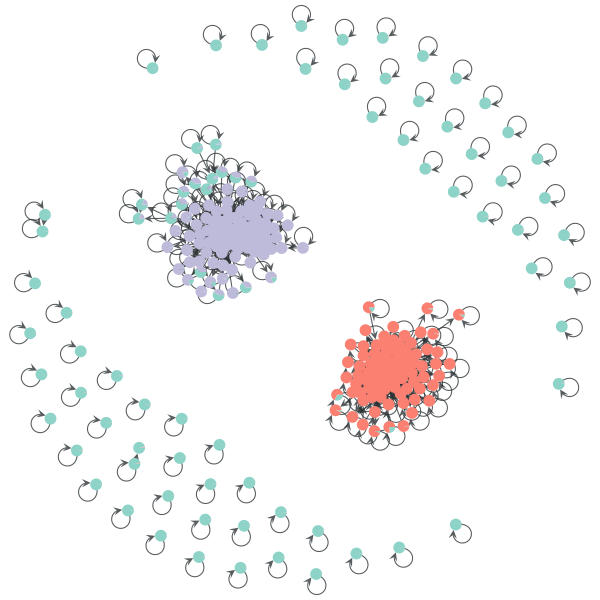

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fd9f96f6940, at 0x7fd9f96e8fd0>

In [13]:
state = gt.minimize_blockmodel_dl(g,B_max=3, deg_corr=True)
#state = gt.BlockState(g,B=2,deg_corr=True)
state.mcmc_sweep(niter=1000)
pv = None
for i in range(1000):
    ret = state.mcmc_sweep(niter=30)
    pv = state.collect_vertex_marginals(pv)
gt.graph_draw(g, vertex_shape="pie",\
    vertex_pie_fractions=pv,output="GrafoAplicaciones.png")